In [1]:
import cv2
import numpy as np
import os
import scipy.io as io
import matplotlib.pyplot as plt
import pickle

# Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras import layers

import random
from tqdm import tqdm
from scipy.spatial.transform import Rotation

In [73]:
IMG_SIZE=96

In [74]:
def get_mask(points, original_frame_shape):
    
    SIZE_X = original_frame_shape[1]
    SIZE_Y = original_frame_shape[0]
    joint_masks = []
    joint_idx = 0
    joints_number = len(points)
    
    for point in points:
        
        mask = np.zeros((IMG_SIZE,IMG_SIZE))
        
        x = point[0]
        y = point[1]

        x = int(x/(SIZE_X/IMG_SIZE))
        y = int(y/(SIZE_Y/IMG_SIZE))
        color = (255,255,255)
        mask = cv2.circle(mask,(x,y),5,color, -1)
        joint_masks.append(mask/255.)
        
    joint_masks = np.array(joint_masks)
    joint_masks = np.swapaxes(joint_masks, 0,-1)
    joint_masks = np.swapaxes(joint_masks, 0,1)
            
    return joint_masks

In [75]:
K1 = np.array([[1.066778e+03, 0.000000e+00, 3.129869e+02],
               [0.000000e+00, 1.067487e+03, 2.413109e+02],
               [0.000000e+00, 0.000000e+00, 1.000000e+00]])

K2 = np.array([[1077.836, 0, 323.7872],
               [0, 1078.189, 279.6921],
               [0,        0,        1]])

verts = [
        [-0.01,0,0],
        [0.08,0.05,0.0],
        [-0.1,0.045,0.0],
        [-0.03,-0.11,0.023],
        [-0.03,-0.11,-0.023],
        [0.055,-0.11,0.023],
        [0.055,-0.11,-0.023]
        ]
verts  = np.array(verts)
color = (0,255,255)

def get_x_y(verts, idx):
    t = poses[idx][4:,None]
    quat = -np.array([*poses[idx][1:4], poses[idx][0]])
    R = np.array(Rotation.from_quat(quat).as_matrix())

    K_ = K1 if idx <= 23820 else K2

    verts_2d = np.matmul(K_, np.matmul(R, verts.T) + t).T
    verts_2d = verts_2d[:,:2] / verts_2d[:,2,None]
    return verts_2d

In [76]:
ycb_path = "C:\\Users\\mati\\Desktop\\Moje\\dyplomowa\\datasets\\ycb_video_sicrod"
power_screwdriver_name = "power_screwdriver"
poses_file_name = "035_power_drill.txt"
poses_file_path = os.path.join(ycb_path,poses_file_name)
frames_path = os.path.join(ycb_path,power_screwdriver_name)

poses = np.loadtxt(poses_file_path)

In [77]:
dir_types = os.listdir(frames_path)
color_frame_paths = []
depth_frame_paths = []

for dir_type in dir_types:
    dir_1 = os.path.join(frames_path,dir_type)
    for file_name in os.listdir(dir_1):
        if "color" in file_name:
            color_frame_paths.append(os.path.join(dir_1,file_name))
        if "depth" in file_name:
            depth_frame_paths.append(os.path.join(dir_1,file_name))

In [80]:
def power_driver_generator():
    while True:
        idx = int(random.random()*len(color_frame_paths))
        color_frame = cv2.imread(color_frame_paths[idx])
        depth_frame = cv2.imread(depth_frame_paths[idx])
        points = get_x_y(verts, idx)

        mask = get_mask(points, original_frame_shape = color_frame.shape[:-1])
        color_frame = cv2.resize(color_frame,(IMG_SIZE,IMG_SIZE))
        depth_frame = cv2.resize(depth_frame,(IMG_SIZE,IMG_SIZE))
        yield color_frame, mask

In [91]:
generator = power_driver_generator()

In [92]:
# plt.rcParams["figure.figsize"] = (5,5)
# x,y = next(generator)
# for i in range(6):
#     plt.subplot(1, 8, i+1)
#     x,y = next(generator)
#     plt.imshow(x)

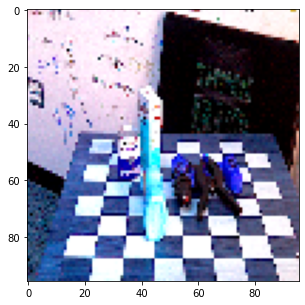

In [124]:
x,y = next(generator)
plt.imshow(x)

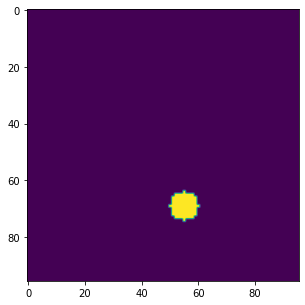

In [125]:
plt.imshow(y[:,:,2])